# Critic

In [193]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
from copy import deepcopy
import warnings
warnings.simplefilter('ignore')
import torchviz
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import joblib
import os
from sklearn.preprocessing import StandardScaler
import time
def get_col(df,name):
    return df.columns[df.columns.str.contains(name)].tolist()
os.listdir('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式')

['#2反應槽(20200201-20200212)開車資料.csv',
 '.ipynb_checkpoints',
 'CAT_life.R',
 'modelpkl',
 'PA_201605-2020001更新R11(20200801).csv',
 'R11註解.txt',
 'runs',
 'tag_cleaned.csv',
 'tag盤點表20200801.csv',
 'tag盤點表20200801.xlsx',
 'train_cleaned(C).csv',
 'train_cleaned(R).csv',
 'train_cleaned(R1).csv',
 'train_cleaned.csv',
 'utils.py',
 'web(R11).py',
 'yo_R11_Actor.ipynb',
 'yo_R11_API_test.ipynb',
 'yo_R11_Critic_Actor.ipynb',
 'yo_R11_ETL.ipynb',
 'yo_R11_preprocessing.ipynb',
 'yo_R11_stream_lasso.ipynb',
 '__pycache__',
 '壓縮檔']

# load data

In [194]:
tag = pd.read_csv('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/tag_cleaned.csv',index_col=0)
tag = tag.loc[tag.category=='可控制因子']

In [195]:
data = joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

In [196]:
data

{'state': array([[9.93778698e-08, 5.52914924e-01],
        [1.06410662e-07, 5.51155175e-01],
        [1.13703815e-07, 5.49462899e-01],
        ...,
        [9.77116164e-01, 4.80888301e-02],
        [9.77127828e-01, 4.65145373e-02],
        [9.77139492e-01, 4.48667581e-02]]),
 'action': array([[[0.62646059, 0.00422802, 0.61905412, ..., 0.91084795,
          0.8612571 , 0.46667935],
         [0.62661047, 0.00414568, 0.61888655, ..., 0.91084795,
          0.8612571 , 0.46686509],
         [0.62669208, 0.00380733, 0.61870886, ..., 0.91084795,
          0.8612571 , 0.46689012],
         ...,
         [0.62715108, 0.00261177, 0.61586571, ..., 0.91072229,
          0.86122883, 0.46695215],
         [0.62715108, 0.00250831, 0.61564464, ..., 0.91059648,
          0.86122883, 0.46695215],
         [0.62721585, 0.00240485, 0.61564464, ..., 0.91059629,
          0.86122883, 0.46697272]],
 
        [[0.62661047, 0.00414568, 0.61888655, ..., 0.91084795,
          0.8612571 , 0.46686509],
         [0

# tensor data

In [197]:
n = 0 
state = torch.FloatTensor(data['state'][n:]) #.cuda()
action = torch.FloatTensor(data['action'][n:]) #.cuda()
output = torch.FloatTensor(data['output'][n:]) #.cuda()
stream = torch.FloatTensor(data['stream'][n:]) #.cuda()

# split data

In [198]:
test_df = pd.read_csv('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/#2反應槽(20200201-20200212)開車資料.csv',
                 index_col=0,
                 parse_dates=True,
                 encoding='latin-1')
test_df = test_df.dropna(axis=0)
print(test_df.shape)

(1585, 97)


In [199]:
sp1 = int(len(state)*0.8)
sp2 = int(len(state)*0.9)
print(sp1,sp2)

42428 47732


# data_iter

In [200]:
train = torch.utils.data.TensorDataset(state[:sp1],action[:sp1],output[:sp1],stream[:sp1])
valid = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])
test = torch.utils.data.TensorDataset(state[sp2:],action[sp2:],output[sp2:],stream[sp2:])

train_iter = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
valid_iter = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)

In [201]:
#print(action.shape)
time_step = action.shape[1]
num_sensor = action.shape[2]

# Construct the neural network

In [202]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.time_step = time_step
        self.num_sensor = num_sensor
        self.h_size = 128
        
        self.output_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Dropout(0.2),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.stream_layer = nn.Sequential(nn.Linear(self.h_size,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,1),
                                         )
        
        self.conv_layer = nn.Sequential(nn.Conv1d(self.num_sensor,self.h_size-1,kernel_size = 36),
                                        nn.ReLU(),
                                       )
        
        self.fc_layer = nn.Sequential(nn.Linear(self.h_size+1,self.h_size),
                                          nn.ReLU(),
                                          nn.Linear(self.h_size,self.h_size),
                                         )
        
    def forward(self,state,action):
        batch_size = state.shape[0]
        
        # action
        action = self.conv_layer(action.permute(0,2,1)).reshape(batch_size,-1)
        
        # combine state action
        combine = torch.cat((state,action),dim=-1)
        
        # fc forward
        combine = self.fc_layer(combine)
        
        # get output and stream
        output = self.output_layer(combine)
        stream = self.stream_layer(combine)
        
        return F.sigmoid(output),F.sigmoid(stream)

In [203]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            #torch.nn.init.xavier_uniform(m.weight)
            torch.nn.init.kaming_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.1)
        except:
            pass

In [204]:
net = Critic() #.cuda()
net.apply(init_weights)

Critic(
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (stream_layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conv_layer): Sequential(
    (0): Conv1d(12, 127, kernel_size=(36,), stride=(1,))
    (1): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

# forward test

In [205]:
a,b = net(state,action)
print(a.shape)
print(b.shape)

torch.Size([53036, 1])
torch.Size([53036, 1])


# tensorboard

In [206]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (test.tensors[0:2]))

# loss and opt

In [207]:
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)

In [208]:
from torch.nn import L1Loss
from torch.nn import SmoothL1Loss

#l1loss = L1Loss()
l1loss = SmoothL1Loss()
def loss_function(output,stream,target_output,target_stream):
    loss = l1loss(output,target_output)
    return loss.mean()    

# train and eval

In [209]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    for epoch in range(num_epochs): 
        
        # train model
        net.train()
        train_loss,i = 0,0
        for state,action,output,stream in train_iter:
            output_pred,stream_pred = net(state,action)
            loss = loss_function(output_pred,stream_pred,output,stream)
            train_loss += loss.item()
            i += 1
            
            # update model
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # eval model (afater update model)
        with torch.no_grad():
            net.eval()
            val_loss,j = 0,0
            for state,action,output,stream in valid_iter:
                output_pred,stream_pred = net(state,action)
                loss = loss_function(output_pred,stream_pred,output,stream)
                val_loss += loss.item()
                j += 1
        
        # caculate avg_loss
        train_avg_loss = train_loss/i
        val_avg_loss = val_loss/j
        
        # save the best_model
        if val_avg_loss <= best_loss:
            best_loss = val_avg_loss
            best_net = deepcopy(net) #backup the model(deepcopy)
            print('model recorded!')
        
        # record history and print loss of the epoch
        train_history.append(train_avg_loss)
        valid_history.append(val_avg_loss)
        print("epochs {} train_avg_loss {:.4f} valid_avg_loss {:.4f}".format(
            epoch,train_avg_loss,val_avg_loss))
        
    # plot result
    print('best val_avg_loss is ',best_loss)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.legend()
    plt.title('loss')
    plt.show()
    
    return best_net.eval()

model recorded!
epochs 0 train_avg_loss 0.0028 valid_avg_loss 0.0020
model recorded!
epochs 1 train_avg_loss 0.0004 valid_avg_loss 0.0015
model recorded!
epochs 2 train_avg_loss 0.0004 valid_avg_loss 0.0015
epochs 3 train_avg_loss 0.0004 valid_avg_loss 0.0016
model recorded!
epochs 4 train_avg_loss 0.0004 valid_avg_loss 0.0014
model recorded!
epochs 5 train_avg_loss 0.0004 valid_avg_loss 0.0013
epochs 6 train_avg_loss 0.0003 valid_avg_loss 0.0013
model recorded!
epochs 7 train_avg_loss 0.0003 valid_avg_loss 0.0012
epochs 8 train_avg_loss 0.0003 valid_avg_loss 0.0014
epochs 9 train_avg_loss 0.0003 valid_avg_loss 0.0014
model recorded!
epochs 10 train_avg_loss 0.0003 valid_avg_loss 0.0011
epochs 11 train_avg_loss 0.0003 valid_avg_loss 0.0012
model recorded!
epochs 12 train_avg_loss 0.0003 valid_avg_loss 0.0007
epochs 13 train_avg_loss 0.0003 valid_avg_loss 0.0010
epochs 14 train_avg_loss 0.0003 valid_avg_loss 0.0024
epochs 15 train_avg_loss 0.0003 valid_avg_loss 0.0010
epochs 16 train_av

epochs 149 train_avg_loss 0.0002 valid_avg_loss 0.0048
epochs 150 train_avg_loss 0.0002 valid_avg_loss 0.0014
epochs 151 train_avg_loss 0.0002 valid_avg_loss 0.0015
epochs 152 train_avg_loss 0.0002 valid_avg_loss 0.0016
epochs 153 train_avg_loss 0.0002 valid_avg_loss 0.0015
epochs 154 train_avg_loss 0.0002 valid_avg_loss 0.0014
epochs 155 train_avg_loss 0.0002 valid_avg_loss 0.0015
epochs 156 train_avg_loss 0.0002 valid_avg_loss 0.0017
epochs 157 train_avg_loss 0.0002 valid_avg_loss 0.0020
epochs 158 train_avg_loss 0.0002 valid_avg_loss 0.0011
epochs 159 train_avg_loss 0.0002 valid_avg_loss 0.0016
epochs 160 train_avg_loss 0.0002 valid_avg_loss 0.0024
epochs 161 train_avg_loss 0.0002 valid_avg_loss 0.0019
epochs 162 train_avg_loss 0.0002 valid_avg_loss 0.0014
epochs 163 train_avg_loss 0.0002 valid_avg_loss 0.0024
epochs 164 train_avg_loss 0.0002 valid_avg_loss 0.0014
epochs 165 train_avg_loss 0.0002 valid_avg_loss 0.0012
epochs 166 train_avg_loss 0.0001 valid_avg_loss 0.0015
epochs 167

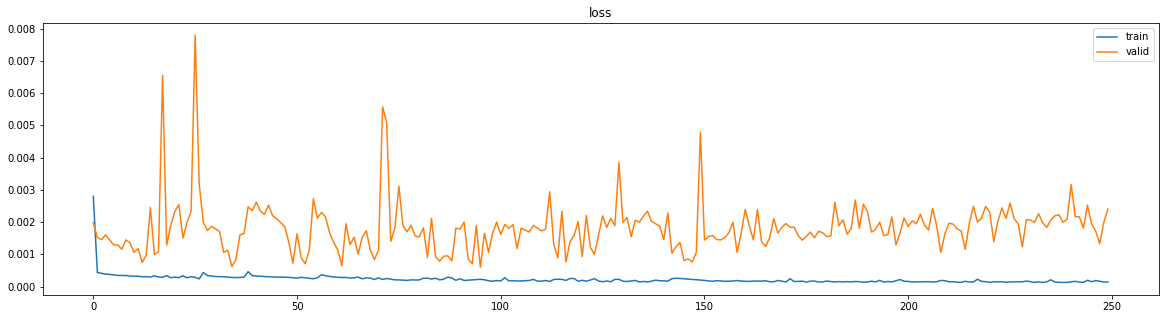

In [210]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [211]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

def mape(a, b): 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()*100

In [212]:
def make_prediction(state,action,output,streamn):
    
    y_pred = net(state,action)[0].detach().cpu().numpy()
    y_pred = data['mm_output'].inverse_transform(y_pred).ravel()
    
    y_pred2 = net(state,action)[1].detach().cpu().numpy()
    y_pred2 = data['mm_stream'].inverse_transform(y_pred2)
    
    y_real = output.detach().cpu().numpy()
    y_real = data['mm_output'].inverse_transform(y_real).ravel()
    
    y_real2 = stream.detach().cpu().numpy()
    y_real2 = data['mm_stream'].inverse_transform(y_real2)
    
    feed = action.detach().cpu().numpy()
    temp = [data['mm_action'].inverse_transform(feed[i]) for i in range(len(feed))]
    feed = np.array(temp)[:,:,0][:,0]
    
    table = pd.DataFrame()
    table['0619'] = feed
    table['0997_real'] = y_real
    table['0997_pred'] = y_pred
    table['真實單耗'] = feed/y_real
    table['預測單耗'] = feed/y_pred
    table['真實蒸氣'] = y_real2
    table['預測蒸氣'] = y_pred2
    
    return table

In [213]:
def make_metric(table):
    
    metric = pd.DataFrame(index=[0],columns=['R2(出料)','RMSE(單耗)','MAPE(單耗)'])
    metric['R2(出料)'] = r2_score(table['0997_real'],table['0997_pred'])
    metric['RMSE(單耗)'] = sqrt(mean_squared_error(table['真實單耗'],table['預測單耗']))
    metric['MAPE(單耗)'] = mape(table['真實單耗'],table['預測單耗'])
    metric.index.name = '出料'
    
    metric2 = pd.DataFrame(index=[0],columns=['R2','RMSE','MAPE'])
    metric2['R2'] = r2_score(table['真實蒸氣'],table['預測蒸氣'])
    metric2['RMSE'] = sqrt(mean_squared_error(table['真實蒸氣'],table['預測蒸氣']))
    metric2['MAPE'] = mape(table['真實蒸氣'],table['預測蒸氣'])
    metric2.index.name = '蒸氣'
    
    return metric,metric2

# train metric

In [214]:
state ,action, output, stream = train_iter.dataset.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.938229,0.028714,0.930349


In [215]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-11.337197,14002.908841,29.199389


# test metric

In [216]:
state ,action, output, stream = test.tensors
table = make_prediction(state,action,output,stream)
metric,metric2 = make_metric(table)
metric

,R2(出料),RMSE(單耗),MAPE(單耗)
出料,,,
0,0.907948,0.046247,2.428885


In [217]:
metric2

,R2,RMSE,MAPE
蒸氣,,,
0,-4.236305,7750.646167,19.641277


# save Critic's .pkl

In [26]:
joblib.dump(net,'C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/Critic.pkl')
print('save done!')
print(time.ctime())

save done!
Wed Oct 28 13:36:12 2020


# ---------------------------------------------------------------
# ---------------------------------------------------------------

# Actor

In [27]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
from torch import nn
import torch
import os
import torch.optim as optim
import warnings
from utils import *
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
torch.cuda.is_available()
os.listdir('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl')

['Critic.pkl', 'dataset.pkl', 'original', 'stream_lasso_weight.pkl']

In [28]:
os.listdir('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式')

['#2反應槽(20200201-20200212)開車資料.csv',
 '.ipynb_checkpoints',
 'CAT_life.R',
 'modelpkl',
 'PA_201605-2020001更新R11(20200801).csv',
 'R11註解.txt',
 'runs',
 'tag_cleaned.csv',
 'tag盤點表20200801.csv',
 'tag盤點表20200801.xlsx',
 'train_cleaned(C).csv',
 'train_cleaned(R).csv',
 'train_cleaned(R1).csv',
 'train_cleaned.csv',
 'utils.py',
 'web(R11).py',
 'yo_R11_Actor.ipynb',
 'yo_R11_API_test.ipynb',
 'yo_R11_Critic_Actor.ipynb',
 'yo_R11_ETL.ipynb',
 'yo_R11_preprocessing.ipynb',
 'yo_R11_stream_lasso.ipynb',
 '__pycache__',
 '壓縮檔']

In [29]:
tag = pd.read_csv('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/tag_cleaned.csv')
tag_map = dict(zip(tag.TAG,tag.chinese))

# Load Critic, lasso_weight and data

In [30]:
critic = joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/Critic.pkl').eval()
lasso_w = torch.FloatTensor(joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/stream_lasso_weight.pkl'))

In [31]:
data = joblib.load('C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/dataset.pkl')
data.keys()

dict_keys(['state', 'action', 'output', 'stream', 'idx', 'mm_state', 'mm_action', 'mm_output', 'mm_stream', 'state_col', 'action_col', 'output_col', 'stream_col'])

# Data iter

In [32]:
state = torch.FloatTensor(data['state'])
request = torch.FloatTensor(np.random.uniform(0,1,size=(state.shape[0],1)))
real_action = torch.FloatTensor(data['action'])
state.shape,request.shape,real_action.shape

(torch.Size([53036, 2]), torch.Size([53036, 1]), torch.Size([53036, 36, 12]))

In [33]:
train = torch.utils.data.TensorDataset(state,request,real_action)
train_iter = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)

# Construct the neural network

In [34]:
data['action'].shape

(53036, 36, 12)

In [35]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_step = data['action'].shape[1]
        self.num_sensor = data['action'].shape[2]
        self.flat_size = self.time_step*self.num_sensor
        self.fc = nn.Sequential(nn.Linear(3,128),nn.ReLU(),nn.Linear(128,self.flat_size))
        
    def forward(self,state,request):
        action = self.fc(torch.cat((state,request),dim=1))
        action = action.view(-1,self.time_step,self.num_sensor)
        return F.sigmoid(action)

In [36]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            #torch.nn.init.xavier_uniform(m.weight)
            torch.nn.init.kaming_uniform(m.weight)
        except:
            pass
    
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0)
        except:
            pass

In [37]:
net = Actor()
net.apply(init_weights)

Actor(
  (fc): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=432, bias=True)
  )
)

# forward test

In [38]:
print(net(state,request).shape)

torch.Size([53036, 36, 12])


# objective

In [39]:
time_step = data['action'].shape[1]
num_sensor = data['action'].shape[2]
print(time_step, num_sensor)

36 12


In [40]:
loss_history = {}
loss_history['loss1'] = []
loss_history['loss2'] = []
loss_history['loss3'] = []
loss_history['loss4'] = []
loss_history['loss5'] = []
loss_history['loss6'] = []
loss_history['loss7'] = []
loss_history['loss8'] = []

In [41]:
def obj_function(action,state,request,real_action):
    
    # critic predict 0997(output) but not predict stream
    #output, _ = critic(state.cuda(),action.cuda())
    output, _ = critic(state.cpu(),action.cpu())
    output = output.cpu()
    
    # only use lasso_w predict stream
    batch_size = action.shape[0]
    A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
    stream = (A@lasso_w).reshape(-1,1)
    
    # 滿足使用者需求(出料等於期望出料)
    loss1 = ((request - output)**2).mean()
    
    # 最小化蒸氣量(愈小愈好)
    loss2 = (stream**2).mean()
    
    # 入料跟出料"質量平衡" #最小化單耗
    feed = action.reshape(-1,time_step,num_sensor)[:,:,0]
    loss3 = ((0.8*feed - request)**2).mean()
    loss8 = (((feed/output) - 0.9)**2).mean()
    
    # 避免鹽浴"溫差太大"
    temp_1 = action.reshape(-1,time_step,num_sensor)[:,:,4]
    temp_2 = action.reshape(-1,time_step,num_sensor)[:,:,-2]
    loss4 = ((temp_1 - temp_2)**2).mean()
    
    # 避免"變異數太大(時間維度上)"
    loss5 = action.reshape(-1,time_step,num_sensor).std(axis=1)
    loss5 = loss5.sum(axis=-1).mean(axis=0) # instance wise => batch wise
    
    #濃度盡量接近90
    loss6 = (action.reshape(-1,time_step,num_sensor)[:,:,-1] - 0.9)**2
    loss6 = loss6.mean()
    
    #避免action跟實際歷史數據差距太大
    loss7 = F.softplus((action.reshape(-1)-real_action.reshape(-1))**2 - 0.1,beta=5).mean()
    
    # 紀錄
    loss_history['loss1'].append(loss1.item())
    loss_history['loss2'].append(loss2.item())
    loss_history['loss3'].append(loss3.item())
    loss_history['loss4'].append(loss4.item())
    loss_history['loss5'].append(loss5.item())
    loss_history['loss6'].append(loss6.item())
    loss_history['loss7'].append(loss7.item())
    loss_history['loss8'].append(loss8.item())
    
    #由於最小化蒸氣量會導致入料跟著最小化會出問題 故將loss2*0
    return loss1 + 0*loss2 + 5*loss3 + loss4 + loss5 + loss6 + loss7 + 5*loss8

In [42]:
obj_function(net(state,request),state,request,real_action)

tensor(1.5947, grad_fn=<AddBackward0>)

# optimizer

In [43]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# training

In [44]:
def train(net,train_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        
        for state,request,real_action in train_iter:
            action = net(
                state,request)
            loss = obj_function(action,state,request,real_action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    return net

epochs 0 loss 1.2207
epochs 1 loss 0.8254
epochs 2 loss 0.6099
epochs 3 loss 0.4713
epochs 4 loss 0.3766
epochs 5 loss 0.3130
epochs 6 loss 0.2721
epochs 7 loss 0.2474
epochs 8 loss 0.2321
epochs 9 loss 0.2215
epochs 10 loss 0.2133
epochs 11 loss 0.2068
epochs 12 loss 0.2014
epochs 13 loss 0.1972
epochs 14 loss 0.1938
epochs 15 loss 0.1911
epochs 16 loss 0.1891
epochs 17 loss 0.1875
epochs 18 loss 0.1862
epochs 19 loss 0.1853
epochs 20 loss 0.1845
epochs 21 loss 0.1838
epochs 22 loss 0.1832
epochs 23 loss 0.1828
epochs 24 loss 0.1823
epochs 25 loss 0.1820
epochs 26 loss 0.1817
epochs 27 loss 0.1814
epochs 28 loss 0.1810
epochs 29 loss 0.1807
epochs 30 loss 0.1805
epochs 31 loss 0.1803
epochs 32 loss 0.1801
epochs 33 loss 0.1799
epochs 34 loss 0.1797
epochs 35 loss 0.1795
epochs 36 loss 0.1794
epochs 37 loss 0.1793
epochs 38 loss 0.1791
epochs 39 loss 0.1790
epochs 40 loss 0.1788
epochs 41 loss 0.1787
epochs 42 loss 0.1786
epochs 43 loss 0.1784
epochs 44 loss 0.1783
epochs 45 loss 0.178

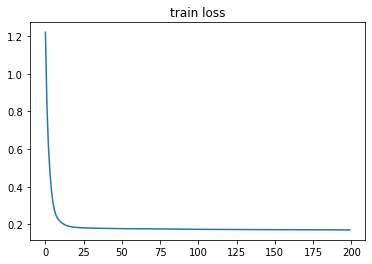

In [45]:
actor = train(net,train_iter,obj_function,optimizer,num_epochs=200)

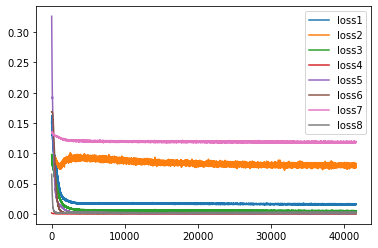

In [46]:
for k,v in loss_history.items():
    plt.plot(pd.Series(v).rolling(5).mean(),label=k)
plt.legend()
plt.show()

# bulid api

In [47]:
class PA_ROBOT:
    def __init__(self):
        self.mm_output = data['mm_output']
        self.mm_stream = data['mm_stream']
        self.mm_state = data['mm_state']
        self.mm_action = data['mm_action']
        self.action_col = data['action_col']
        self.tag_map = tag_map
        self.actor = actor
        self.critic = critic
        self.lasso_w = lasso_w
    
    def get_advice(self,state,request):
        
        # sacle input
        request = self.mm_output.transform([[request]])
        state = self.mm_state.transform([state])
        
        # tensor format input
        request = torch.FloatTensor([request]).reshape(-1,1)
        state = torch.FloatTensor(state)
        
        # actor forward
        action = self.actor(state,request)
        
        # critic forward but not predict stream
        #output,_ = self.critic(state.cuda(),action.cuda())
        output,_ = self.critic(state.cpu(),action.cpu())
        
        # lasso predict stream
        batch_size = action.shape[0]
        A = torch.cat((action.reshape(batch_size,-1),state),dim=-1)
        stream = (A@lasso_w).reshape(-1,1)
        
        # inverse transform
        output = output.detach().cpu().numpy()
        output = self.mm_output.inverse_transform(output)
        stream = stream.detach().cpu().numpy()
        stream = self.mm_stream.inverse_transform(stream)
        action = action.detach().cpu().numpy()
        action = np.array([self.mm_action.inverse_transform(i) for i in action]).squeeze(0)
        
        # create advice DataFrame
        advice = pd.DataFrame(index = self.action_col)
        advice['chinese'] = advice.index.map(self.tag_map) 
        advice['mean'] = action.mean(axis=0)
        advice['max'] = action.max(axis=0)
        advice['min'] = action.min(axis=0)
        
        # feed
        feed = advice.loc['MLPAP_FQ-0619.PV','mean']
        return advice,output,stream,feed/output[0][0],feed/stream[0][0]

In [48]:
robot = PA_ROBOT()

In [49]:
advice,output,stream,單耗,蒸氣單耗 = robot.get_advice([0.5,0.5],8000)
print('output:',output,'stream:',stream,'單耗',單耗,'蒸氣單耗',蒸氣單耗)
advice

output: [[8643.76]] stream: [[28692.037]] 單耗 0.8784663 蒸氣單耗 0.26464668


,chinese,mean,max,min
MLPAP_FQ-0619.PV,OX入料量,7593.251953,7632.329102,7553.746094
MLPAP_TJC-0627.PV,OX預熱器出口溫度,153.111649,153.394211,152.775848
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,174.148361,175.085541,173.004044
MLPAP_FR-0632.PV,汽機風量,82.761932,82.978493,82.550316
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,350.956757,351.363647,350.535339
MLPAP_PIC-0761.PV,鹽浴冷卻器(E212)出口壓力,47.413170,47.673717,47.235889
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,59.790432,60.122501,59.521835
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,182.281662,182.923294,181.538925
MLPAP_TRC-0747.PV,E220出口溫度,148.054245,149.349838,146.163040
MLPAP_TJR-0881.PV,NaN,143.031876,144.459137,141.580795


# save PAagent's .pkl

In [50]:
joblib.dump(robot,'C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/PAagent.pkl')

['C:/Users/bigje/Desktop/AI中心/yo-jupyter/R11程式/modelpkl/PAagent.pkl']